# Peng's updated Kristjan's Bandit Algorithm for HS2

In [2]:
#Imports

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import pickle


In [3]:
#A bandit model, consisting of reward coefficient mean and covariance

# From Peng's 2-1 algorithm; action-centered bandit (algorithm 2)


class model:
    def __init__(self,mu,Sigma):
        self.mu = mu
        self.Sigma = Sigma
        

#THE BANDIT CODE (in class form)

class ContextBandit:
    #Bandit Object
    def __init__(self,nInteract, pc_params,prior_model, gamma, fc_params, f_baseline, f_interact, sigma2 = 1., prior_weight = 1.):
        '''
        pc_params: (pi_min, pi_max) parameters for probability clipping
        prior_model: prior Gaussian model with \mu_\beta, \Sigma_\beta
        gamma: gamma for GP Prior
        fc_params: feedback controller parameters: (\lambda_c, N_c, T_c)
            T_c: maximum number of decision times to count dosage
        f_baseline: baseline feature mapping; f: S \to R^p_1
        f_interact: interaction feature mapping; f_interact: S' \to R^p_2
        sigma2: reward noise estimate (variance)
        prior_weight: how much to weigh prior, set to 1 for full weight
        '''
        #initialize input parameters
        self.nInteract = nInteract
        self.pi_min = pc_params[0]
        self.pi_max = pc_params[1]
        self.gamma = gamma
        self.sigma2 = sigma2

        self.f_baseline = f_baseline
        self.f_interact = f_interact

        self.lambda_c = fc_params[0]
        self.N_c = fc_params[1]
        self.T_c = fc_params[2]

        # self.v = 1e-1 #tuning parameter - multiplier on bandit prior covariances 

        
        #Initialize model to prior data model
        # Mean = prior_weight * prior_model.mu,
        # Cov = I_n + prior_weight * prior_model.Sigma
        
        self.prior_model = prior_model

        # This is mu and Sigma
        self.current_model = model(prior_weight*prior_model.mu,
            np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        # This is mu' and Sigma'
        self.daystart_model = model(prior_weight*prior_model.mu,
            np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        
    def process_context(self, I_T, S_T, N_t):
        '''
        Inputs context for a given decision point,
        updates the current day's model, and returns action probability alpha

        Line 20 of algorithm

        I_T: Current availability
        S_T: Current state
        N_t: Dosage over past T_c decision times; number of messages sent since present minus T_c
        Returns: alpha, probability of taking action 1
        '''
        if I_T == 1:
            current_model = self.current_model
            # Current Posterior mean and variance for interaction term
            mu2 = current_model.mu[1:1+self.nInteract]
            Sigma2 = current_model.Sigma[1:1+self.nInteract,1:1+self.nInteract]

            # Compute probability of unclipped randomization probability
            X_mean = self.f_interact(S_T).T.dot(mu2) - self.lambda_c*(N_t - self.N_c)*(N_t - self.N_c > 0)
            X_var = self.f_interact(S_T).dot(Sigma2.dot(self.f_interact(S_T).T))

            # Actual probability
            pi_t = 1 - norm.cdf(0, X_mean, np.sqrt(X_var))

            if pi_t < self.pi_min:
                alpha = self.pi_min
            elif pi_t > self.pi_max:
                alpha = self.pi_max
            else: 
                alpha = pi_t
            # print(mean, variance, alpha)

        else:
            alpha = 0

        # Update current model to posterior of Gaussian Process
        self.current_model.mu = (1-self.gamma)*self.prior_model.mu + self.gamma * self.current_model.mu
        self.current_model.Sigma = (1 - self.gamma ** 2.) * self.prior_model.Sigma + (self.gamma ** 2.) * self.current_model.Sigma 

            
        return alpha #probability of taking action 1

        
    ######
    
    def update_model(self, S_T, R_T, A_T, pi_T, I_T, t = 5):
        # Update at end of day
        '''
        At end of day, updates the model given the 
        S_T: states for day T
        R_T: rewards for day T
        A_T: actions for day T
        pi_T: probabilities of action 1 for day T
        I_T: availability for each time point on day T
        t: number of decision points per day, defaults to 5
        '''

        # Set aliases for the current model
        current_model = self.current_model
        current_model.mu = self.daystart_model.mu
        current_model.Sigma = self.daystart_model.Sigma

        for dpt in range(t):
            # If available then:
            if I_T[dpt]:
                f_t = np.concatenate([self.f_baseline(S_T[dpt]), (A_T[dpt] - pi_T[dpt]) * self.f_interact(S_T[dpt])], axis=0)
            
                
                Sigma_dot_f_t = np.expand_dims(current_model.Sigma.dot(f_t),1)
                denom = self.sigma2 + f_t.T.dot(Sigma_dot_f_t)
                beta = current_model.mu + (R_T[dpt] - f_t.T.dot(current_model.mu)) / denom * Sigma_dot_f_t
                Omega = current_model.Sigma - 1. / denom * Sigma_dot_f_t.dot(Sigma_dot_f_t.T)
                current_model.mu = self.gamma * beta           + (1 - self.gamma) * self.prior_model.mu
                current_model.Sigma = (self.gamma ** 2.) * Omega + (1 - self.gamma ** 2.) * self.prior_model.Sigma
                



        
        # New day, new model

        self.daystart_model.mu = current_model.mu.copy()
        self.daystart_model.Sigma = current_model.Sigma.copy()
        
########


In [4]:
# HS Analysis Functions

### Aux Functions for reading two different .csv files ###
def read_hs1(yoozer, hs1_file = "../../../Data/suggest-analysis-kristjan.csv"):
    pd_df = pd.read_csv(hs1_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)
    
    
    return ddf,pd_df

def read_hs1_gf(yoozer, hs1_gf_file = '../../../Data/suggest-kristjan.csv'):
    pd_df = pd.read_csv(hs1_gf_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)

    return ddf,pd_df


def nan_equal(a,b):
    return ((a == b) | (np.isnan(a) & np.isnan(b))).all()

def read_data(N, T, t, nBaseline):
    ### Read in Feature vector, Reward Vector, and Action Vector for each user ###
    # Also Standardizes all features

    max_yoozer = N+1

    featVec = np.empty((max_yoozer,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((max_yoozer,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((max_yoozer,T*t))
    actionVec.fill(np.nan)

    # Bias term

    for yoozer in range(1,max_yoozer):
    #     print("Processeing User: ", yoozer)

        ddf,pd_df = read_hs1(yoozer)
        #Make features
        #Center and scale
        decision_ind = ddf['decision.index.nogap']
        reward_h = ddf['jbsteps30.log']
        send_any = ddf['send']
        send_active = ddf['send.active']

        assert np.all(send_any == send_active)

        #total_sent = ddf['totalSent']
        # Study day index
        dazze = ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = (ddf['study.day.nogap'] - np.mean(pd_df['study.day.nogap']))/np.std(pd_df['study.day.nogap'])#Number sent in last whatever
        #Add feature for # of week period (hsteps v2) WATCH OUT FOR COLINEARITY WITH INTERCEPT

        # Ohter location indicator
        loc_ind = ddf['loc.is.other']

        # Std deviation of step count in last 7 days
        steps_sd = (ddf['window7.steps60.sd'] - np.mean(pd_df['window7.steps60.sd']))/np.std(pd_df['window7.steps60.sd'])

        # Step count in previous 30 minutes
        state = (ddf['jbsteps30pre.log'] - np.mean(pd_df['jbsteps30pre.log']))/np.std(pd_df['jbsteps30pre.log'])

        # Work location indicator
        #wrk_ind = ddf['location.category'], #loc_ind = ddf['location.category']
        wrk_ind = ddf['loc.is.work'] #compare to string “work”

        # Square root steps yesterday
        steps_yest = (ddf['steps.yesterday.sqrt'] - np.mean(pd_df['steps.yesterday.sqrt']))/np.std(pd_df['steps.yesterday.sqrt'])

        # Temperature, set -1024 as 0
        temp = (ddf['temperature'] - np.mean(pd_df['temperature']))/np.std(pd_df['temperature'])
        temp[ddf['temperature'] == -1024] = 0

        ddfgf,pd_dfgf = read_hs1_gf(yoozer)

        # ?? Unclear what this is
        # Reward: Step count in 30 minutes following decision point
        steps_gf = (np.log(ddfgf['gfsteps30pre'] + .5) - np.mean(np.log(pd_dfgf['gfsteps30pre'] + .5))/np.std(np.log(pd_dfgf['gfsteps30pre']+.5)))

        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[yoozer,:end_ind] = reward_h.astype(float)
        actionVec[yoozer,:end_ind] = send_any.astype(float)

        featVec[yoozer,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[yoozer,:end_ind,1] = day_ind #study.day.nogap
        featVec[yoozer,:end_ind,2] = loc_ind.astype(int) # loc.is.other
        featVec[yoozer,:end_ind,3] = steps_sd.astype(float) # window7.steps60.sd
        featVec[yoozer,:end_ind,4] = state # jbsteps30pre.log
        featVec[yoozer,:end_ind,5] = wrk_ind.astype(int) # loc.is.work
        featVec[yoozer,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[yoozer,:end_ind,7] = temp.astype(float) # temperature

        # This was included but didn't make too much sense
    #     featVec[yoozer,:end_ind,8] = steps_gf.astype(float)[:day_ind.shape[0]]
    
    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    return featVec, rewardVec, actionVec

def resid_regression(N, T, t, nBaseline, rewardVec, actionVec, featVec):
    '''Perform Regression on Pooled R ~ A*S' + S to create Residuals'''
    # Actual Dimensions of A and S
    a_dim = 1
    s_dim = nBaseline

    # Copy for notational ease
    R = rewardVec.copy()
    A = actionVec.copy()
    S = featVec.copy()


    # Fit OLS r ~ (a_t s'_t, s_t)^T \eta, where s' are interact terms and s are all baseline
    resid_model = sm.OLS(endog = R.reshape(N*T*t), exog = np.concatenate([(A * S[:,:,1:1+nInteract]), S], 2).reshape((N*T*t,(nInteract + nBaseline))), missing = "drop")
    resids_unproc = resid_model.fit().resid

    # Parameters
    Etas_fit = resid_model.fit().params


    ## Fill resids ##

    # Copy shape and location of nans
    resids = rewardVec.copy()

    curr_ind = 0
    for n in range(N):

        old_ind = curr_ind
        curr_ind += R[n][~np.isnan(R[n])].shape[0]

        # Copy in indices
        resids[n][:curr_ind-old_ind] = resids_unproc[old_ind:curr_ind]
    
    return resids, Etas_fit


# # Code to Generate Simulated Users
def generate_new_users(resids, A, S, N_new, T_new, T, t, users_to_sample = 10):
    '''
    Generates new random user
    
    Inputs:
        resids: Residuals
        A: Actions
        S: States
        N_new: Int of number of new users to generate from sampling
        T_new: Int of number of days for each new user
    
    Returns:
        resids_new: Matrix of resids for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      resids: (N, T * t) 
      A: (N, T * t, )
    '''
    
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.empty((N_new, users_to_sample)).astype(int)

    # Loop to reset sampling without replacement for each new user
    for i in range(N_new):
        sampled_user_indices[i] = np.random.choice(N, size = users_to_sample, replace = False)
    
    # Concatenate resids, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(resids,2),A,S], axis = 2)
    sampled_users_untreated = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, users_to_sample * T*t, 1 + a_dim + s_dim)
    sampled_users = np.empty((N_new, T_new * t, 1 + a_dim + s_dim))
    
    for i in range(N_new):
        
        # Cast to DataFrame to dropna, reset index to shift datapoints up to be consecutive, takes T_new * t datapoints
        sampled_users[i] = pd.DataFrame(sampled_users_untreated[i]).apply(lambda col: col.dropna().reset_index().iloc[:,-1], axis = 0).as_matrix()[:T_new * t]
        
    # Sampled Generated residuals
    resids_new = sampled_users[:,:,0].reshape(N_new, T_new, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T_new, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T_new, t, s_dim)
    
    return resids_new, A_new, S_new



def reward_func(resid, a, s, Eta, nInteract = 3):
    '''Basic reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.'''
    return(resid + np.concatenate([a * np.take(s,range(1,1+nInteract),-1), s], a.ndim-1).dot(Eta))



In [5]:
## Creating Simulations

# Counts from HS 1
N = 48
T = 41
t = 5
nBaseline = 1+7
nInteract = 3 # Add 1 for bias term

N_new = 20
T_new = 90

S, R, A = read_data(N, T, t, nBaseline)
resids, Etas_fit = resid_regression(N, T, t, nBaseline, R, A, S)
resids_new, A_new, S_new = generate_new_users(resids, A, S, 20, 90, T, t)
I_new = np.ones_like(A_new)


C:\Users\isaac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: DtypeWarning: Columns (15,16,18,60,61,96,97,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# VARIABLES FROM ABOVE CELL

S_new # Baseline States for simulated users
resids_new # Residuals; note this does not match up with Kristjan's Eta definition (he treats this as baseline OLS coefficient)

# Etas[0:3] is action*interact features
# Etas[3] is state bias (1's)
# Etas[4:11] are baseline features
Etas_fit

array([-0.21181203, -0.16692167,  0.08116949,  3.04487594, -0.02305797,
        0.06443497,  0.18900795,  1.36208089,  0.30135504,  0.23107337,
        0.38301622])

In [7]:
#Create a reward function from true coefficients, with residuals non-mandatory
def reward(featVec,action,coef0,coef1, resid = 0):
    
    nInteract = len(coef1)
    
    predictors = np.concatenate([action * np.take(featVec,range(1,1+nInteract),-1), featVec], 0)
    Eta = np.concatenate([coef1, coef0])
    
    return(resid + np.dot(predictors, Eta))

In [8]:
#A simulation of above standard model.

def f_baseline(featVec):
    return featVec

def f_interact(featVec):
    return featVec[1:1+3]


def run_simulation(coef0, coef1, S_sim, I_sim, resids_sim, reward_func, prior_model,
                   fc_params, nInteract = 3, nBaseline = 7+1, pc_params = [.2, .8],
                   f_baseline = f_baseline, f_interact = f_interact,
                   gamma = 1., sigma2 = 1. , T = 90, t = 5, no_resid_flag = False):
    '''
    coef0: Reward coefficients for baseline (PHI), first element is bias term
    coef1: Reward coefficients for interaction (THETA); note that concatenated, [THETA, PHI] = Eta
    S_sim: simulated states
    I_sim: simulated availabilities; 1 = available, 0 = unavailable
    resids_sim: Residuals of simulated users
    reward_func: reward function, must have type reward(featVec, action, coef0, coef1, resid)
    nInteract: Number of interaction features
    nBaseline: Number of baseline features
    params: Bandit parameters; [minprob, maxprob, priorweight]
    T: days of study
    t: decision points per day
    no_resid_flag: If True will substitute 0 for residuals, if False will use true residuals
    '''
    N = S_sim.shape[0]
    assert T == S_sim.shape[1]
    assert t == S_sim.shape[2]
    assert nBaseline == S_sim.shape[3]
    
    #creating variables for saving history of what we do
    regret = np.empty((N, T, t))
    probs  = np.empty((N, T, t))
    action = np.empty((N, T, t))
    regret.fill(np.nan)
    probs.fill(np.nan)
    action.fill(np.nan)
    
    # Containers for bandit parameters
    bandit_covs = np.empty((N, T,t, nInteract+nBaseline, nInteract+nBaseline))
    bandit_covs.fill(np.nan)
    bandit_means = np.empty((N, T,t, nInteract+nBaseline))
    bandit_means.fill(np.nan)

    for sim_user_index in range(N):

        #Create a bandit object for each user
        bandit = ContextBandit(nInteract, pc_params, prior_model, gamma, fc_params, f_baseline, f_interact, sigma2) #Create and initialize bandit

        #Cycle thru days
        for day in range(T):

            rwd = np.zeros(t)
            featVec = np.zeros((nBaseline,t))
            #Cycle thru decision points in each day
            for dpt in range(t):
                #Generate random state vector 
                featVec[:,dpt] = S_sim[sim_user_index, day, dpt]
                user_resid = resids_sim[sim_user_index, day, dpt]
                if no_resid_flag:
                    user_resid = 0
                    
                #Get action probability from bandit
                
                # probs[] is the probability of taking action 1 at current decision point, i.e. \pi_t(1|s_t) in the doc (Quality metrics 1&2).
                # featInteract = S_sim[sim_user_index, day, dpt, 1:1+nInteract] #only use the interaction features, but first element is bias
                if False: #Do nothing
                    probs[sim_user_index, day, dpt] = 0
                else: #Use bandit
                    # Count dosage from previous N_c days
                    N_t = np.sum(action[sim_user_index].reshape(-1)[max(0,day*t + dpt - bandit.N_c):day*t + dpt])
                    # Compute clipped probability
                    probs[sim_user_index, day, dpt] = bandit.process_context(
                    I_sim[sim_user_index, day, dpt], S_sim[sim_user_index, day, dpt], N_t)


                #Choose action based on probability, i.e. do the randomization
                if np.random.rand() < probs[sim_user_index, day, dpt]:
                    action[sim_user_index, day, dpt] = 1
                else:
                    action[sim_user_index, day, dpt] = 0

                #Receive reward from the universe. 
                rwd[dpt] = reward(S_sim[sim_user_index, day, dpt], action[sim_user_index, day, dpt], coef0, coef1, user_resid)
                rwd[dpt] = reward(S_sim[sim_user_index, day, dpt], action[sim_user_index, day, dpt], coef0, coef1, user_resid)


                #What was expected regret given probability chosen by bandit?
                #(easy to do since we know the \theta coefficients, reward under action 1 is reward under action 0 plus \theta^T s_t, and vice versa)
                rwd0 = reward(S_sim[sim_user_index, day, dpt], 0, coef0, coef1, user_resid) # do we want to include user_resid here or use default 0?
                rwd1 = reward(S_sim[sim_user_index, day, dpt], 1, coef0, coef1, user_resid)

                #Expected reward under bandit policy
                rwdExp = probs[sim_user_index, day, dpt]*rwd1 + (1-probs[sim_user_index, day, dpt])*rwd0

                #Regret is difference between optimal reward and the reward we got
                #"Optimal" reward is restricted based on the min/max allowed probabilities
                #ISAAC: THIS IS THE REGRET AT THE CURRENT DECISION POINT. Cumulative regret is formed by summing this up from time 0 to the current time.
                regret[sim_user_index,  day, dpt] = max(pc_params[0]*rwd0 + pc_params[1]*rwd1, pc_params[0]*rwd1 + pc_params[1]*rwd0) - rwdExp


            #Perform bandit updates at end of day
            for dpt in range(t):
                bandit_covs[sim_user_index, day, dpt] = bandit.daystart_model.Sigma
#                 print(bandit_means[sim_user_index, day, dpt].shape, bandit.daystart_model.mu.flatten().shape)
                bandit_means[sim_user_index, day, dpt] = bandit.daystart_model.mu.flatten()
                bandit.update_model(S_sim[sim_user_index, day], rwd, action[sim_user_index, day], probs[sim_user_index, day], I_sim[sim_user_index, day])
                #bandit.update_model(np.concatenate([[1],featVec[1:nInteract+1,dpt],featVec[1+nInteract:,]]),rwd[dpt],np.zeros(nInteract),action[sim_user_index, day, dpt],probs[sim_user_index, day, dpt])


    return regret.reshape((N,T*t)), probs.reshape((N,T*t)), action.reshape((N,T*t)), bandit_covs.reshape((N,T*t, nInteract+nBaseline,nInteract+nBaseline)), bandit_means.reshape((N,T*t, nInteract+nBaseline)), bandit


In [24]:
# TEST GAMMA
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))
fc_params = [1., 5, 10]

regrets = []
probs = []
actions = []
bandit_covs = []
bandi_means = []
gammas = [0.01,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.]
for gamma in :
    print(gamma)
    regret, prob, action, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma)
    regrets.append(regret)
    probs.append(prob)
    actions.append(action)
    bandit_covs.append(bandit_cov)
    bandit_means.append(bandit_mean)

0.01
0.1
0.2
0.3
0.5
0.6
0.7
0.8
0.9
0.95
0.99
1.0


In [32]:
len(regrets)

900

In [39]:
for i in range(len(regrets)):
    np.save('results/regrets' + str(i) +'.npy',regrets[i])
    np.save('results/probs' + str(i) +'.npy',probs[i])
    np.save('results/actions' + str(i) +'.npy',actions[i])
    np.save('results/bandit_covs' + str(i) +'.npy',bandit_covs[i])
    np.save('results/bandit_means' + str(i) +'.npy',bandit_means[i])
    

In [38]:
regret_results = []
prob_results = []
action_results = []
bandit_cov_results = []
bandit_mean_results = []


for i in range(900):
    regret_results.append(np.load("results/regrets" + str(i) + '.npy'))
    prob_results.append(np.load("results/probs" + str(i) + '.npy'))
    action_results.append(np.load("results/actions" + str(i) + '.npy'))
    bandit_cov_results.append(np.load("results/bandit_covs" + str(i) + '.npy'))
    bandit_mean_results.append(np.load("results/bandit_means" + str(i) + '.npy'))

(20, 450)

In [29]:
import _pickle

In [28]:
!pip install cPickle

  Could not find a version that satisfies the requirement cPickle (from versions: )
No matching distribution found for cPickle


In [ ]:
print('hi')

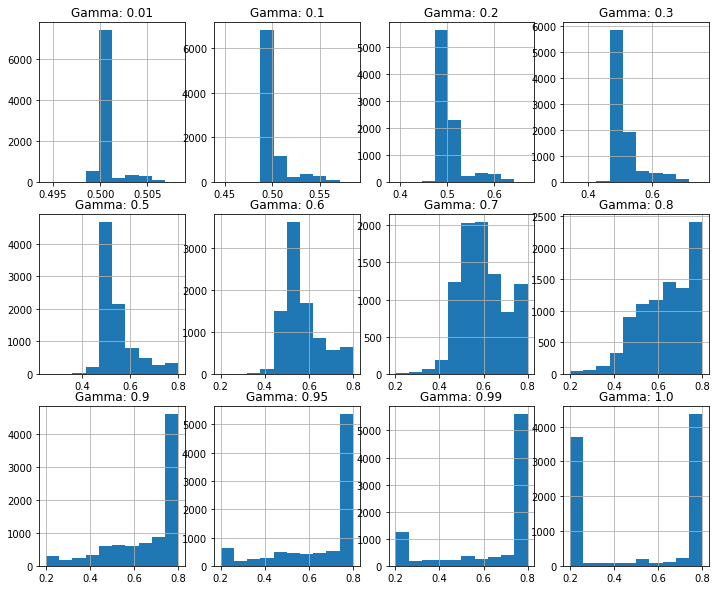

In [43]:
fig,axes = plt.subplots(3,4,figsize = (12,10))
for prob,ax,gamma in zip(probs,axes.flat,gammas):
#     fig,ax = plt.subplots()
    pd.Series(prob.flatten()).hist(ax = ax)
    ax.set_title("Gamma: "+ str(gamma))

In [11]:
# TEST GAMMA
prior_mdl = model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline))


regrets = []
probs = []
actions = []
bandit_covs = []
bandit_means = []


gammas = [0.1,0.5,0.7,0.8,0.9]
lambdas = [0.1, 0.25, 0.5, 0.75, 1., 10.]
N_c_mults = [0.1, 0.25, 0.5, 0.75, 0.9]
T_cs = [5, 10, 20, 35, 50, 70]

for gamma in gammas:
    for lamb in lambdas:
        for N_c_mult in N_c_mults:
            for T_c in T_cs:
                print(gamma, lamb, N_c_mult, T_c)
                fc_params = [lamb, int(N_c_mult*T_c), T_c]
                regret, prob, action, bandit_cov, bandit_mean, bandit = run_simulation(coef0 = Etas_fit[3:11], coef1 = Etas_fit[0:3], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, reward_func = reward, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma)
                regrets.append(regret)
                probs.append(prob)
                actions.append(action)
                bandit_covs.append(bandit_cov)
                bandit_means.append(bandit_mean)

0.1 0.1 0.1 5
0.1 0.1 0.1 10
0.1 0.1 0.1 20
0.1 0.1 0.1 35
0.1 0.1 0.1 50
0.1 0.1 0.1 70
0.1 0.1 0.25 5
0.1 0.1 0.25 10
0.1 0.1 0.25 20
0.1 0.1 0.25 35
0.1 0.1 0.25 50
0.1 0.1 0.25 70
0.1 0.1 0.5 5
0.1 0.1 0.5 10
0.1 0.1 0.5 20
0.1 0.1 0.5 35
0.1 0.1 0.5 50
0.1 0.1 0.5 70
0.1 0.1 0.75 5
0.1 0.1 0.75 10
0.1 0.1 0.75 20
0.1 0.1 0.75 35
0.1 0.1 0.75 50
0.1 0.1 0.75 70
0.1 0.1 0.9 5
0.1 0.1 0.9 10
0.1 0.1 0.9 20
0.1 0.1 0.9 35
0.1 0.1 0.9 50
0.1 0.1 0.9 70
0.1 0.25 0.1 5
0.1 0.25 0.1 10
0.1 0.25 0.1 20
0.1 0.25 0.1 35
0.1 0.25 0.1 50
0.1 0.25 0.1 70
0.1 0.25 0.25 5
0.1 0.25 0.25 10
0.1 0.25 0.25 20
0.1 0.25 0.25 35
0.1 0.25 0.25 50
0.1 0.25 0.25 70
0.1 0.25 0.5 5
0.1 0.25 0.5 10
0.1 0.25 0.5 20
0.1 0.25 0.5 35
0.1 0.25 0.5 50
0.1 0.25 0.5 70
0.1 0.25 0.75 5
0.1 0.25 0.75 10
0.1 0.25 0.75 20
0.1 0.25 0.75 35
0.1 0.25 0.75 50
0.1 0.25 0.75 70
0.1 0.25 0.9 5
0.1 0.25 0.9 10
0.1 0.25 0.9 20
0.1 0.25 0.9 35
0.1 0.25 0.9 50
0.1 0.25 0.9 70
0.1 0.5 0.1 5
0.1 0.5 0.1 10
0.1 0.5 0.1 20
0.1 0.5 0.1 

0.7 10.0 0.5 5
0.7 10.0 0.5 10
0.7 10.0 0.5 20
0.7 10.0 0.5 35
0.7 10.0 0.5 50
0.7 10.0 0.5 70
0.7 10.0 0.75 5
0.7 10.0 0.75 10
0.7 10.0 0.75 20
0.7 10.0 0.75 35
0.7 10.0 0.75 50
0.7 10.0 0.75 70
0.7 10.0 0.9 5
0.7 10.0 0.9 10
0.7 10.0 0.9 20
0.7 10.0 0.9 35
0.7 10.0 0.9 50
0.7 10.0 0.9 70
0.8 0.1 0.1 5
0.8 0.1 0.1 10
0.8 0.1 0.1 20
0.8 0.1 0.1 35
0.8 0.1 0.1 50
0.8 0.1 0.1 70
0.8 0.1 0.25 5
0.8 0.1 0.25 10
0.8 0.1 0.25 20
0.8 0.1 0.25 35
0.8 0.1 0.25 50
0.8 0.1 0.25 70
0.8 0.1 0.5 5
0.8 0.1 0.5 10
0.8 0.1 0.5 20
0.8 0.1 0.5 35
0.8 0.1 0.5 50
0.8 0.1 0.5 70
0.8 0.1 0.75 5
0.8 0.1 0.75 10
0.8 0.1 0.75 20
0.8 0.1 0.75 35
0.8 0.1 0.75 50
0.8 0.1 0.75 70
0.8 0.1 0.9 5
0.8 0.1 0.9 10
0.8 0.1 0.9 20
0.8 0.1 0.9 35
0.8 0.1 0.9 50
0.8 0.1 0.9 70
0.8 0.25 0.1 5
0.8 0.25 0.1 10
0.8 0.25 0.1 20
0.8 0.25 0.1 35
0.8 0.25 0.1 50
0.8 0.25 0.1 70
0.8 0.25 0.25 5
0.8 0.25 0.25 10
0.8 0.25 0.25 20
0.8 0.25 0.25 35
0.8 0.25 0.25 50
0.8 0.25 0.25 70
0.8 0.25 0.5 5
0.8 0.25 0.5 10
0.8 0.25 0.5 20
0.8 0.25 

In [23]:
results = [regrets, probs, actions, bandit_means, bandit_covs]

In [11]:
bandit_means[:,-1,:].mean(axis=0)

array([ 3.10865709, -0.08888395,  0.10159862,  0.27720841,  1.22102856,
        0.35033489,  0.11793383,  0.26297994, -0.25819153, -0.02495706,
        0.15896695])

In [205]:
bandit.current_model.mu

array([[ 2.03507751],
       [-0.23862681],
       [ 0.93685995],
       [ 0.11502493],
       [ 1.15672226],
       [ 1.43328968],
       [ 0.50885485],
       [-0.84432457],
       [-0.30012531],
       [-0.3068412 ],
       [ 0.3963952 ]])

In [12]:
Etas_fit

array([-0.21181203, -0.16692167,  0.08116949,  3.04487594, -0.02305797,
        0.06443497,  0.18900795,  1.36208089,  0.30135504,  0.23107337,
        0.38301622])

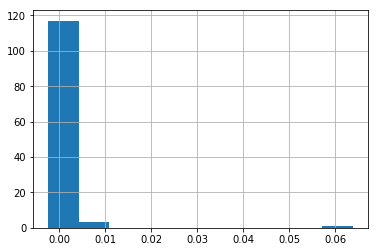

In [13]:
i = 14
pd.Series(bandit_covs[0][i*30].flatten()).hist()

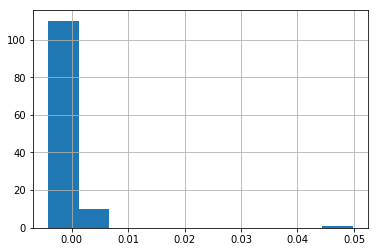

In [16]:
pd.Series(bandit.current_model.Sigma.flatten()).hist()

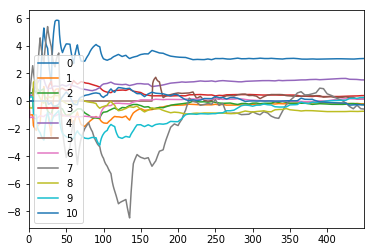

In [17]:
pd.DataFrame(bandit_means[0]).plot()

C:\Users\isaac\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


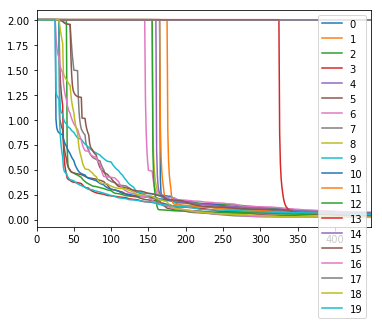

In [18]:
eigs = np.empty((N_new, T_new*t, 11))
for n in range(N_new):
    for time in range(T_new*t):
        eigs[n, time] = np.linalg.eigvals(bandit_covs[n, time])
pd.DataFrame(np.max(eigs,axis = -1)).T.plot()

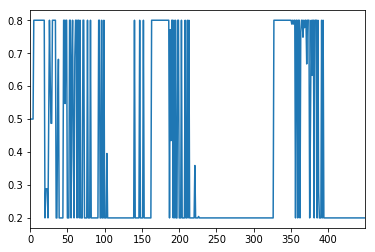

In [20]:
# Probability of 
pd.DataFrame(probs.T).iloc[:,0].plot()

# Posterior Mean changes?
# Posterior Variance changes? (too small/big?)

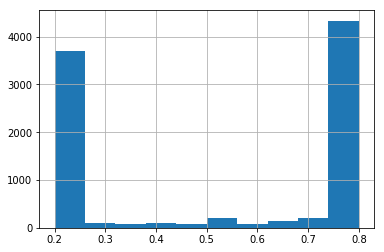

In [21]:
# Hist of probabilities
pd.Series(probs.flatten()).hist()

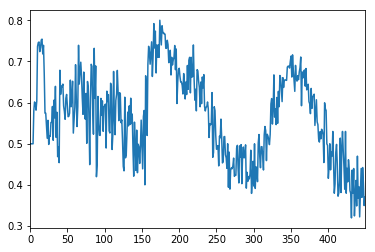

In [199]:
# Plot of mean (over users) probability over time
pd.Series(np.mean(probs, axis = 0)).plot()



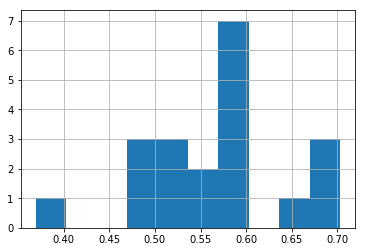

In [200]:
# Histogram of mean probabilities per user
pd.Series(np.mean(probs, axis = 1)).hist()

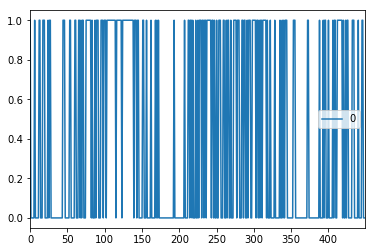

In [165]:
# Actions actually taken
pd.DataFrame(action[0].T).plot()

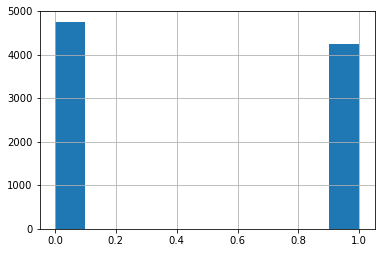

In [166]:
pd.Series(action.flatten()).hist()

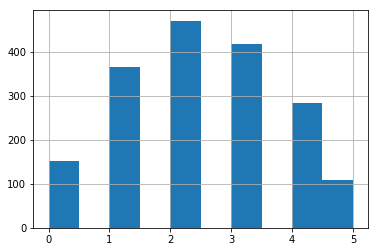

In [167]:
# Hist of number of actions taken per day (out of 5)
pd.Series(np.sum(action.reshape((N_new, T_new, t)), axis = 2).flatten()).hist()



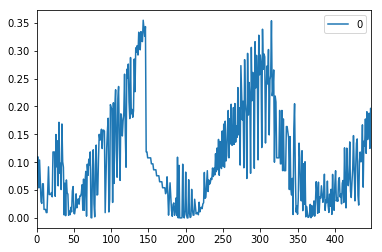

In [168]:
pd.DataFrame(regret[0].T).plot()

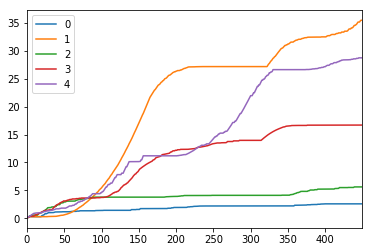

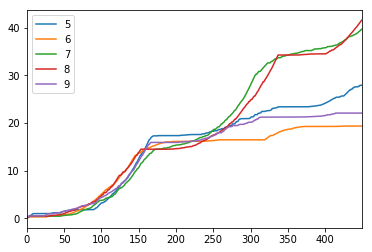

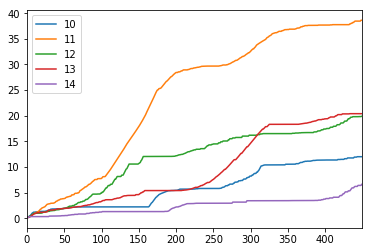

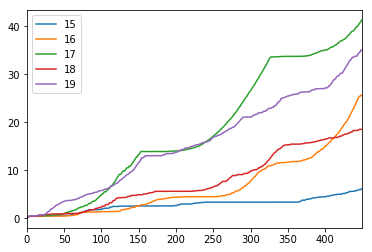

In [23]:
# Cumulative regret for users
for i in range(N_new):
    if i%5 == 0:
        (np.cumsum(pd.DataFrame(regret), axis = 1))[i:i+5].T.plot()
    
    

In [ ]:
# Todo:

# Understand algorithm (Current Bandit, simulation data, generative model, tuning parameters etc)
# Future: How to generate data where features are based on prior actions?

# See difference between 1 user and averaged N>1 users

# Feedback controller:
# Currently not implemented
# First step: understand impact of \alpha based on quality metrics